>>>>>>>> <p style="font-size:50px;"><b> StackOverflow Tag Prediction </p>

In [43]:
import pickle
import joblib

import re
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd
import sqlite3 as sql
from sqlalchemy import create_engine

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

import nltk
# nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import metrics

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p style='font-size:18px'><b> Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

<p style='font-size:18px'><b> Source:  </b> https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/</p>


<h2> 1.2 Source / useful links </h2>


Data Source : https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data <br>
Youtube : https://youtu.be/nNDqbUhtIRg <br>
Research paper : https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tagging-1.pdf <br>
Research paper : https://dl.acm.org/citation.cfm?id=2660970&dl=ACM&coll=DL

<h2> 1.3 Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints. Few minutes would be ok, like 2-5 minutes.

Precision and Racall explanation: <br>
>> Say for an (Title,Description) say there are 4 appropriate tags : T1,T2,T3,T4 <br>
But we predicted T1,T2,T3,T5 <br>
So we predicted T5 which is not correct, i.e we provided an incorrect tag so our precision decreases. <br>
Also we missed out T4 which was supposed to be there, i.e we missed an correct tag so our recall decreases.

<h1>2. Machine Learning problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />


__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

<h3>2.1.2 Example Data point </h3>

<pre>
<b>Title</b>:  Implementing Boundary Value Analysis of Software Testing in a C++ program?
<b>Body </b>: <pre><code>
        #include&lt;
        iostream&gt;\n
        #include&lt;
        stdlib.h&gt;\n\n
        using namespace std;\n\n
        int main()\n
        {\n
                 int n,a[n],x,c,u[n],m[n],e[n][4];\n         
                 cout&lt;&lt;"Enter the number of variables";\n         cin&gt;&gt;n;\n\n         
                 cout&lt;&lt;"Enter the Lower, and Upper Limits of the variables";\n         
                 for(int y=1; y&lt;n+1; y++)\n         
                 {\n                 
                    cin&gt;&gt;m[y];\n                 
                    cin&gt;&gt;u[y];\n         
                 }\n         
                 for(x=1; x&lt;n+1; x++)\n         
                 {\n                 
                    a[x] = (m[x] + u[x])/2;\n         
                 }\n         
                 c=(n*4)-4;\n         
                 for(int a1=1; a1&lt;n+1; a1++)\n         
                 {\n\n             
                    e[a1][0] = m[a1];\n             
                    e[a1][1] = m[a1]+1;\n             
                    e[a1][2] = u[a1]-1;\n             
                    e[a1][3] = u[a1];\n         
                 }\n         
                 for(int i=1; i&lt;n+1; i++)\n         
                 {\n            
                    for(int l=1; l&lt;=i; l++)\n            
                    {\n                 
                        if(l!=1)\n                 
                        {\n                    
                            cout&lt;&lt;a[l]&lt;&lt;"\\t";\n                 
                        }\n            
                    }\n            
                    for(int j=0; j&lt;4; j++)\n            
                    {\n                
                        cout&lt;&lt;e[i][j];\n                
                        for(int k=0; k&lt;n-(i+1); k++)\n                
                        {\n                    
                            cout&lt;&lt;a[k]&lt;&lt;"\\t";\n               
                        }\n                
                        cout&lt;&lt;"\\n";\n            
                    }\n        
                 }    \n\n        
                 system("PAUSE");\n        
                 return 0;    \n
        }\n
        </code></pre>\n\n
        <p>The answer should come in the form of a table like</p>\n\n
        <pre><code>       
        1            50              50\n       
        2            50              50\n       
        99           50              50\n       
        100          50              50\n       
        50           1               50\n       
        50           2               50\n       
        50           99              50\n       
        50           100             50\n       
        50           50              1\n       
        50           50              2\n       
        50           50              99\n       
        50           50              100\n
        </code></pre>\n\n
        <p>if the no of inputs is 3 and their ranges are\n
        1,100\n
        1,100\n
        1,100\n
        (could be varied too)</p>\n\n
        <p>The output is not coming,can anyone correct the code or tell me what\'s wrong?</p>\n'
<b>Tags </b>: 'c++ c'
</pre>

<h2>2.2 Mapping the real-world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
__Credit__:  http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3>2.2.2 Performance metric </h3>

The normal metrics we would use in tha case of classification problem were Pre,Rec,F1,AUC,log-loss. But these made perfect sense with binary/multi-class classification, and does not correspond in Multi-label classification. So we have to adopt some new metric based on the fact that we need high precision and recall.

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

- <b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

 - <b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>

<image src="images/capture.png" height=450px>

- <b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

below-> Xi is actuallt Yi^(hat)

<image src="images/capture2.png" height=450px>

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading and Cleaning </h2>

<h3>3.1.1 Using Pandas with SQLite to Load the data</h3>

In [15]:
if not os.path.isfile('data/train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///data/train.db')
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('data/Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

180000 rows
360000 rows
540000 rows
720000 rows
900000 rows
1080000 rows
1260000 rows
1440000 rows
1620000 rows
1800000 rows
1980000 rows
2160000 rows
2340000 rows
2520000 rows
2700000 rows
2880000 rows
3060000 rows
3240000 rows
3420000 rows
3600000 rows
3780000 rows
3960000 rows
4140000 rows
4320000 rows
4500000 rows
4680000 rows
4860000 rows
5040000 rows
5220000 rows
5400000 rows
5580000 rows
5760000 rows
5940000 rows
6120000 rows
Time taken to run this cell : 0:03:16.217194


<h3> 3.1.2 Counting the number of rows </h3>

In [11]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sql.connect('data/train.db')
    num_rows = pd.read_sql_query("""SELECT COUNT(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['COUNT(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:00:00.232163


In [15]:
start = datetime.now()
con = sql.connect('data/train.db')
df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
con.close()
print("Time taken to count the number of rows :", datetime.now() - start)

Time taken to count the number of rows : 0:02:07.821225


In [20]:
print('No. of duplicate questions: ',num_rows['COUNT(*)'].values[0]-df_no_dup.shape[0],'(',((num_rows['COUNT(*)'].values[0]-df_no_dup.shape[0])*100)/num_rows['COUNT(*)'].values[0],')')

No. of duplicate questions:  1827881 ( 30.292038906260252 )


In [23]:
# number of times each question appeared in our database
df_no_dup['cnt_dup'].value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

`So in above results 2656284 questions are unique, and then 1272336 no. of questions have been repeated 2 times hence contributing to 1272336 duplicates, similarly 277575 questions have repeated for 3 times hence contributing to 555150(2*277575) duplicates, and henceforth...`

- ### Tag Count

In [48]:
# removing the data points with no tags
df_no_dup[df_no_dup['Tags'].isna()]

,Title,Body,Tags,cnt_dup
777547,Do we really need NULL?,<blockquote>\n <p><strong>Possible Duplicate:...,None,1
962680,Find all values that are not null and not in a...,<p>I am running into a problem which results i...,None,1
1126558,Handle NullObjects,<p>I have done quite a bit of research on best...,None,1
1256102,How do Germans call null,"<p>In german null means 0, so how do they call...",None,1
2430668,Page cannot be null. Please ensure that this o...,<p>I get this error when i remove dynamically ...,None,1
3329908,"What is the difference between NULL and ""0""?","<p>What is the difference from NULL and ""0""?</...",None,1
3551595,a bit of difference between null and space,<p>I was just reading this quote</p>\n\n<block...,None,2


In [49]:
df_no_dup[df_no_dup['Tags'].isna()].shape

(7, 4)

In [53]:
df_no_dup[~df_no_dup['Tags'].isna()].shape[0],df_no_dup.shape[0]-7

(4206308, 4206308)

In [3]:
df_no_dup = df_no_dup[~df_no_dup['Tags'].isna()]

In [4]:
df_no_dup['TagCounts'] = df_no_dup['Tags'].apply(lambda x: len(x.split()))
df_no_dup.head()

,Title,Body,Tags,cnt_dup,TagCounts
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [56]:
# distribution of number of tags per question
df_no_dup['TagCounts'].value_counts()

3    1206157
2    1111706
4     814996
1     568291
5     505158
Name: TagCounts, dtype: int64

<h2> 3.2 Analysis of Tags </h2>

<h3> 3.2.1 Total number of unique tags </h3>

In [19]:
tags_lst = [x for tgs in df_no_dup['Tags'] for x in tgs.split()]
tags_lst[:15]

['c++',
 'c',
 'c#',
 'silverlight',
 'data-binding',
 'c#',
 'silverlight',
 'data-binding',
 'columns',
 'jsp',
 'jstl',
 'java',
 'jdbc',
 'facebook',
 'api']

In [61]:
len([x for tgs in df_no_dup['Tags'] for x in tgs.split()])

12195948

In [66]:
uni_tags= set(([x for tgs in df_no_dup['Tags'] for x in tgs.split()]))

In [65]:
len(set(([x for tgs in df_no_dup['Tags'] for x in tgs.split()])))

42049

In [20]:
tags_freq_dict = dict(Counter(tags_lst))

In [85]:
freq_vals = list(tags_freq_dict.values())
freq_vals.sort()
freq_vals[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

- #### Precentile calculation of frequencies of Tags

In [90]:
for i in range(0,90,10):
    print('The {}th percentile of duration attribute is :{}'.format(i,np.percentile(freq_vals,i)))
for i in range(90,99,1):
    print('The {}th percentile of duration attribute is :{}'.format(i,np.percentile(freq_vals,i)))
for i in np.linspace(99.0,100.0,11):
    print('The {}th percentile of duration attribute is :{}'.format(i,np.percentile(freq_vals,i)))

The 0th percentile of duration attribute is :1.0
The 10th percentile of duration attribute is :2.0
The 20th percentile of duration attribute is :4.0
The 30th percentile of duration attribute is :7.0
The 40th percentile of duration attribute is :11.0
The 50th percentile of duration attribute is :17.0
The 60th percentile of duration attribute is :27.0
The 70th percentile of duration attribute is :48.0
The 80th percentile of duration attribute is :97.0
The 90th percentile of duration attribute is :278.0
The 91th percentile of duration attribute is :325.0
The 92th percentile of duration attribute is :380.0
The 93th percentile of duration attribute is :459.0
The 94th percentile of duration attribute is :559.0
The 95th percentile of duration attribute is :712.0
The 96th percentile of duration attribute is :922.0
The 97th percentile of duration attribute is :1231.5599999999977
The 98th percentile of duration attribute is :1970.0400000000009
The 99.0th percentile of duration attribute is :3956

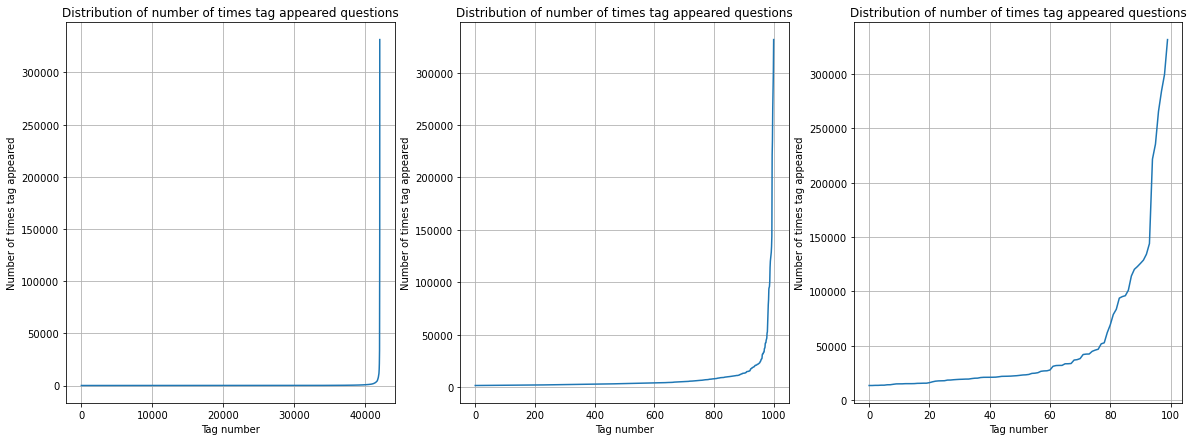

In [107]:
rcParams['figure.figsize'] = 20,7
plt.subplot(131)
plt.plot(freq_vals)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")

plt.subplot(132)
plt.plot(freq_vals[-1000:])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")

plt.subplot(133)
plt.plot(freq_vals[-100:])
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")

plt.show()

` This shows that very very less tags have very very high frequencies`

Last 100 points

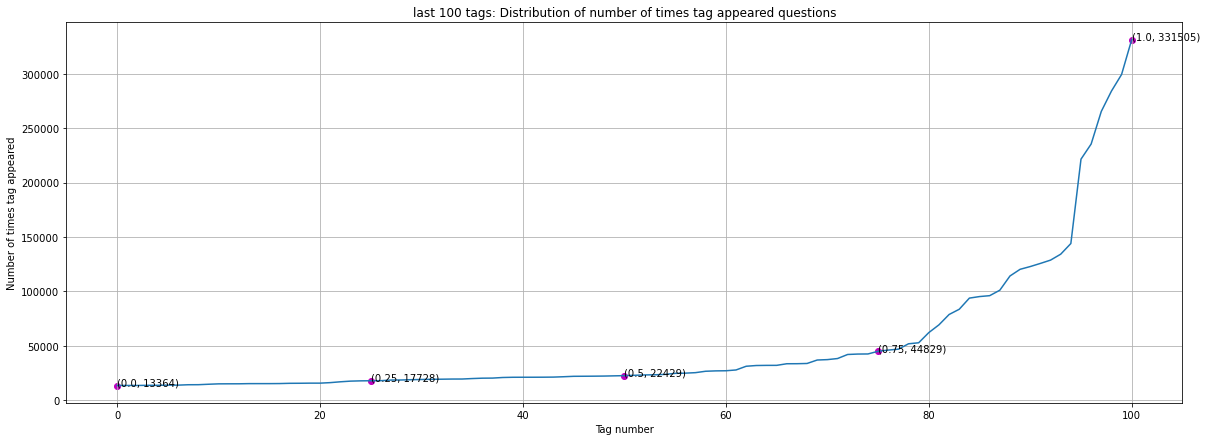

In [131]:
plt.plot(freq_vals[-101:])
plt.title("last 100 tags: Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")

plt.scatter(x=list(range(0,101,25)), y=freq_vals[-101::25], c='m', label = "quantiles with 0.25 intervals")
for i in range(5):
    plt.gca().annotate((list(range(0,101,25))[i]/100,freq_vals[-101::25][i]),(list(range(0,101,25))[i],freq_vals[-101::25][i]))

plt.show()

In [137]:
np_freq_vals = np.array(freq_vals)
print(sum(np_freq_vals>10000),' Tags are been used for more than 10000 times')
print(sum(np_freq_vals>100000),' Tags are been used for more than 100000 times')
most_frequent = max(tags_freq_dict,key = lambda x: tags_freq_dict[x] )
print("The most repeated tag is {} , which has been repeated {} no. of times".format(most_frequent,tags_freq_dict[most_frequent])) 

153  Tags are been used for more than 10000 times
14  Tags are been used for more than 100000 times
The most repeated tag is c# , which has been repeated 331505 no. of times


<b>Observations:</b>

1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this problem.
         &nbsp     (to understand this statement you have to watch the explanation on micro-averaged F1 score by AAI)

<h3> 3.2.4 Tags Per Question </h3>

In [5]:
df = df_no_dup
df.head()

,Title,Body,Tags,cnt_dup,TagCounts
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [9]:
print( "Maximum number of tags per question: %d"%df['TagCounts'].max())
print( "Minimum number of tags per question: %d"%df['TagCounts'].min())
print( "Avg. number of tags per question: %f"% ((sum(df['TagCounts'])*1.0)/len(df['TagCounts'])))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899442


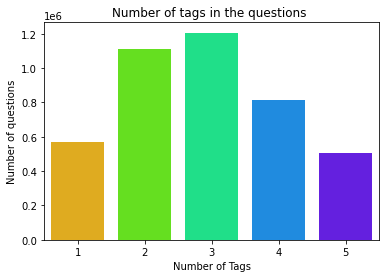

In [16]:
sns.countplot(df['TagCounts'], palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />

1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

<h3>3.2.5 Most Frequent Tags </h3>

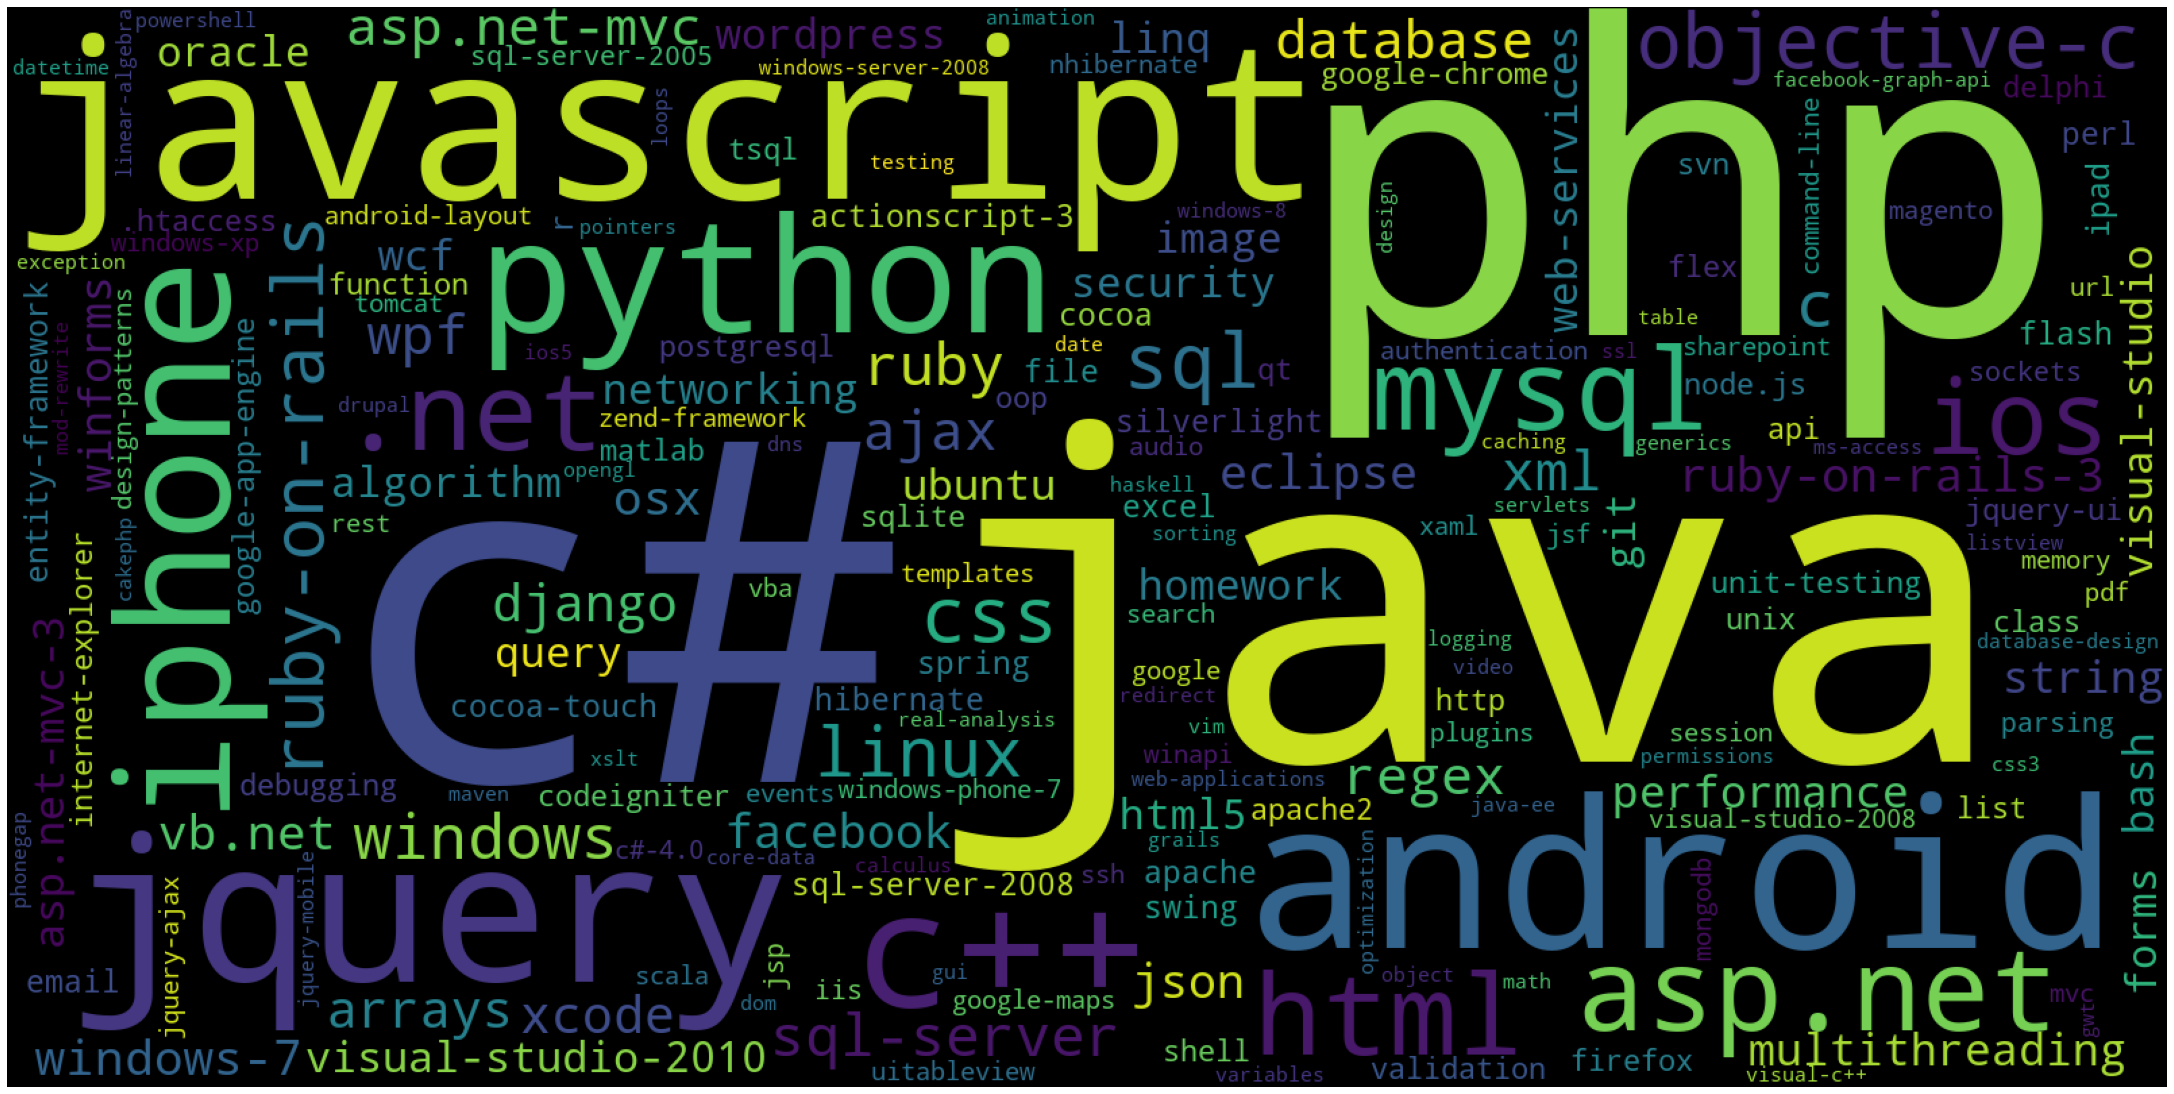

Time taken to run this cell : 0:00:10.255720


In [23]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(tags_freq_dict.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
# fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

In [37]:
tags_freq_dict = dict(sorted(tags_freq_dict.items(),key = lambda x: x[1],reverse=True))

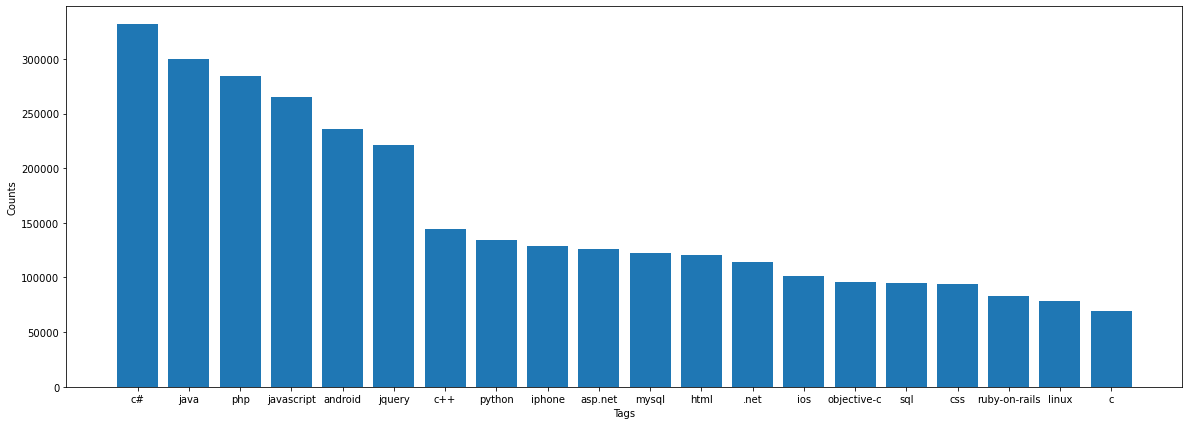

In [42]:
rcParams['figure.figsize'] = 20,7
plt.bar(list(tags_freq_dict.keys())[:20],list(tags_freq_dict.values())[:20])
plt.ylabel('Counts')
plt.xlabel('Tags')
plt.show()

<b>Observations:</b><br />

1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

<h3> 3.3 Cleaning and preprocessing of Questions </h3>

<h3> 3.3.1 Preprocessing </h3>

<ol> 
    <li> Sample 1M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [11]:
# df['f_bdy'] = df['Body'].apply(lambda text :re.sub(r"<.*?>"," ",text))
# def clean_html(df):
#     return df['Body'].apply(lambda text :re.sub(r"<.*?>"," ",text))

In [14]:
print(df['f_bdy'][40],'\n--------------------------------------\n')
print(df['Body'][40])

 So I got this piece of code: 

  frame = MyFrame(None, -1)
index = frame.list.InsertStringItem(sys.maxint, "test")
frame.list.SetStringItem(index, 1, "test")
  

 However when it should execute, nothing changes in the  ListCtrl  of  MyFrame .
It even seems like it creates an own hidden  listCtrl  with "test" in it but leaves the original unchanged. 
 
--------------------------------------

<p>So I got this piece of code:</p>

<pre><code>frame = MyFrame(None, -1)
index = frame.list.InsertStringItem(sys.maxint, "test")
frame.list.SetStringItem(index, 1, "test")
</code></pre>

<p>However when it should execute, nothing changes in the <code>ListCtrl</code> of <code>MyFrame</code>.
It even seems like it creates an own hidden <code>listCtrl</code> with "test" in it but leaves the original unchanged.</p>



In [16]:
conn = sql.connect('data/train.db')

In [18]:
cursr = conn.cursor()

In [39]:
que = "select name from sqlite_master where type='table'"
table_names = cursr.execute(que)
tables = table_names.fetchall()
len(tables),tables[0][0]

(1, 'data')

In [53]:
temp = df['Body'][0].encode()
type(temp)

bytes

In [58]:
df['Body'][0].encode('utf-8')

b'<pre><code>#include&lt;iostream&gt;\n#include&lt;stdlib.h&gt;\n\nusing namespace std;\n\nint main()\n{\n         int n,a[n],x,c,u[n],m[n],e[n][4];\n         cout&lt;&lt;"Enter the number of variables";\n         cin&gt;&gt;n;\n\n         cout&lt;&lt;"Enter the Lower, and Upper Limits of the variables";\n         for(int y=1; y&lt;n+1; y++)\n         {\n                 cin&gt;&gt;m[y];\n                 cin&gt;&gt;u[y];\n         }\n         for(x=1; x&lt;n+1; x++)\n         {\n                 a[x] = (m[x] + u[x])/2;\n         }\n         c=(n*4)-4;\n         for(int a1=1; a1&lt;n+1; a1++)\n         {\n\n             e[a1][0] = m[a1];\n             e[a1][1] = m[a1]+1;\n             e[a1][2] = u[a1]-1;\n             e[a1][3] = u[a1];\n         }\n         for(int i=1; i&lt;n+1; i++)\n         {\n            for(int l=1; l&lt;=i; l++)\n            {\n                 if(l!=1)\n                 {\n                    cout&lt;&lt;a[l]&lt;&lt;"\\t";\n                 }\n            }\n  

In [86]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext

start = datetime.now()
len_pre=0
len_post=0
questions_with_code = 0
questions_proccesed = 0
data = list()

for index, row in tqdm(df.iterrows()):
    is_code = 0
    title, question, tags = row['Title'], row['Body'], row['Tags']

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    code = re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL)

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    # question=striphtml(question.encode('utf-8'))
    question=striphtml(question) # we are not using the encode() because we may use them when we need the '\n' in the results from regular expression, but here we do not require that, as we ultimately remove them when processing stopwords. 
    # title=title.encode('utf-8')

    question=title+" "+question
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(question.lower())

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    questions_proccesed += 1
    len_post+=len(question)
    data.append([question,code,tags,x,len(question),is_code])
    if questions_proccesed == 1000000:
        break

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed
print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))
print("Time taken to run this cell :", datetime.now() - start)
ndf = pd.DataFrame(data,columns=['question','code','tags','pre_len','post_len','iscode'])

999999it [24:51, 670.62it/s]
Avg. length of questions(Title+Body) before processing: 1208
Avg. length of questions(Title+Body) after processing: 339
Percent of questions containing code: 56
Time taken to run this cell : 0:24:51.163008


In [88]:
ndf

,question,code,tags,pre_len,post_len,iscode
0,implement boundari valu analysi softwar test c...,[#include&lt;iostream&gt;\n#include&lt;stdlib....,c++ c,2116,145,1
1,dynam datagrid bind silverlight bind datagrid ...,[MyClass myInstance = new MyClass();\ndataGrid...,c# silverlight data-binding,904,184,1
2,dynam datagrid bind silverlight bind datagrid ...,[MyClass myInstance = new MyClass();\ndataGrid...,c# silverlight data-binding columns,904,184,1
3,java lang noclassdeffounderror javax servlet j...,"[&lt;%@taglib prefix=""c"" uri=""http://java.sun....",jsp jstl,745,311,1
4,java sql sqlexcept microsoft odbc driver manag...,"[try {\n Class.forName(""sun.jdbc.odbc.JdbcO...",java jdbc,1056,105,1
...,...,...,...,...,...,...
999995,forcibl creat directori hard link understand r...,"[ln, ln]",shell hard-link ln,1721,986,1
999996,forcibl creat new contact insert new raw conta...,"[RawContact, Contact, RawContact, RawContact, ...",android android-contacts,1125,399,1
999997,forcibl discard python imag librari imag recla...,[for fn in filenames:\n im = Image.open(fn)...,python memory python-imaging-library,965,412,1
999998,forcibl exclud waypoint http call option googl...,[],google-maps-api-3,911,448,0


### AAI method with sql


In [ ]:
 
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")


#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

In [ ]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

__ we create a new data base to store the sampled and preprocessed questions __

In [ ]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/

start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [ ]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

In [ ]:
#Taking 1 Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

----
AAI method ends


<h1>4. Machine Learning Models </h1>

<h2> 4.1 Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [157]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(ndf['tags'])

vectorizer_4gram = CountVectorizer(tokenizer = lambda x: x.split(), binary='true',ngram_range=(1,4))
multilabel_y_4gram = vectorizer_4gram.fit_transform(ndf['tags'])

In [158]:
multilabel_y.shape,multilabel_y_4gram.shape

((1000000, 34872), (1000000, 1687030))

__ We will sample the number of tags instead considering all of them (due to limitation of computing power) __ This is because, we have almost 34K tags, and we have to do an Multi Labeled Classification, so we need to make the use of some modified algorithms. Say we are using the one vs rest Logistic Regression, in this case we need to train almost 34K models, as we require one model foe one tag. Which is computationally not feasible to us. So we are going to sample Tags on the basis of their frequencies i.e we would sample the most frequent tags only.

In [160]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def tags_to_choose2(n):
    t = multilabel_y_4gram.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y_4gram[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

def questions_explained_fn2(n):
    multilabel_yn = tags_to_choose2(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [175]:
t = multilabel_y_4gram.sum(axis=0).tolist()[0]
sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
multilabel_yn_4gram=multilabel_y_4gram[:,sorted_tags_i[:1000]]
x= multilabel_yn.sum(axis=1)
x

matrix([[3],
        [4],
        [4],
        ...,
        [2],
        [1],
        [2]], dtype=int64)

In [179]:
np.count_nonzero(x==0)

70400

In [128]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=ndf.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

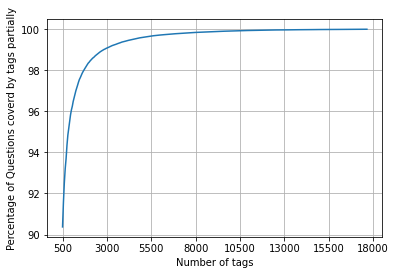

with  5500 tags we are covering  99.082 % of questions


In [144]:
plt.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
plt.gca().set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Percentage of Questions coverd by tags partially")
plt.grid()
plt.show()
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [145]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

number of questions that are not covered : 9179 out of  1000000
Number of tags in sample : 34872
number of tags taken : 5500 ( 15.771966047258545 %)


__ We consider top 15% tags which covers  99% of the questions __

### Same analysis for 4-gram features

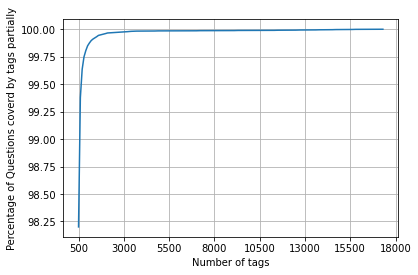

with  5000 tags we are covering  98.2 % of questions
with  15000 tags we are covering  99.377 % of questions


In [188]:
questions_explained2 = []
total_tags2=multilabel_y_4gram.shape[1]
total_qs2=ndf.shape[0]
for i in range(5000, total_tags2, 10000):
    questions_explained2.append(np.round(((total_qs2-questions_explained_fn2(i))/total_qs2)*100,3))

plt.plot(questions_explained2)
xlabel = list(500+np.array(range(-50,650,50))*50)
plt.gca().set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Percentage of Questions coverd by tags partially")
plt.grid()
plt.show()
print("with ",5000,"tags we are covering ",questions_explained2[0],"% of questions")
print("with ",15000,"tags we are covering ",questions_explained2[1],"% of questions")

In [189]:
multilabel_yx_4gram = tags_to_choose2(5000)
print("number of questions that are not covered :", questions_explained_fn2(5000),"out of ", total_qs2)
print("Number of tags in sample :", multilabel_y_4gram.shape[1])
print("number of tags taken :", multilabel_yx_4gram.shape[1],"(",(multilabel_yx_4gram.shape[1]/multilabel_y_4gram.shape[1])*100,"%)")

number of questions that are not covered : 18002 out of  1000000
Number of tags in sample : 1687030
number of tags taken : 5000 ( 0.2963788432926504 %)


__ We consider top 0.29% tags which covers  98% of the questions __

### You need to understand that the processing we did on the Tags is our 'y' data, so multilabel_yx and multilabel_yx_4gram are our 'y' data and the ndf ['questions'] are our 'x' data. Which we are going to featurize in coming cells (tf-idf).

<h2>4.2 Split the data into test and train (80:20) </h2>

In [192]:
total_size=ndf.shape[0]
train_size=int(0.80*total_size)

x_train=ndf.head(train_size)
x_test=ndf.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

y_train2 = multilabel_yx_4gram[0:train_size,:]
y_test2 = multilabel_yx_4gram[train_size:total_size,:]

In [193]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)
print("Number of data points in train2 data :", y_train2.shape)
print("Number of data points in test2 data :", y_test2.shape)

Number of data points in train data : (800000, 5500)
Number of data points in test data : (200000, 5500)
Number of data points in train2 data : (800000, 5000)
Number of data points in test2 data : (200000, 5000)


In [197]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:05:05.451683


In [199]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)
print("Dimensions of train data X:",x_train_multilabel.shape, "Y2 :",y_train2.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y2:",y_test2.shape)

Dimensions of train data X: (800000, 92466) Y : (800000, 5500)
Dimensions of test data X: (200000, 92466) Y: (200000, 5500)
Dimensions of train data X: (800000, 92466) Y2 : (800000, 5000)
Dimensions of test data X: (200000, 92466) Y2: (200000, 5000)


#### As in AAI we have already made aware about skmultilearn library. So they tried to use it, but as we have used td-idf and bow vectorizer we have got sparse martix in return, and skmulti learn only work with dense matrix.

In [ ]:
# https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
#https://stats.stackexchange.com/questions/117796/scikit-multi-label-classification
# classifier = LabelPowerset(GaussianNB())
"""
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=21)

# train
classifier.fit(x_train_multilabel, y_train)

# predict
predictions = classifier.predict(x_test_multilabel)
print(accuracy_score(y_test,predictions))
print(metrics.f1_score(y_test, predictions, average = 'macro'))
print(metrics.f1_score(y_test, predictions, average = 'micro'))
print(metrics.hamming_loss(y_test,predictions))

"""
# we are getting memory error because the multilearn package 
# is trying to convert the data into dense matrix
# ---------------------------------------------------------------------------
#MemoryError                               Traceback (most recent call last)
#<ipython-input-170-f0e7c7f3e0be> in <module>()
#----> classifier.fit(x_train_multilabel, y_train)

<h2> 4.4 Applying Logistic Regression with OneVsRest Classifier </h2>

In [204]:
with open("data/chkpt1.pickle","wb") as f:
    pickle.dump(ndf, f)
    pickle.dump(multilabel_yx, f)
    pickle.dump(multilabel_yx_4gram, f)
    pickle.dump(x_train, f)
    pickle.dump(x_test, f)
    pickle.dump(y_train, f)
    pickle.dump(y_test, f)
    pickle.dump(y_train2, f)
    pickle.dump(y_test2, f)
    pickle.dump(x_train_multilabel, f)
    pickle.dump(x_test_multilabel, f)

In [6]:
with open("data/chkpt1.pickle","rb") as f:
    ndf  = pickle.load(f)
    multilabel_yx    = pickle.load(f)
    multilabel_yx_4gram  = pickle.load(f)
    x_train  = pickle.load(f)
    x_test   = pickle.load(f)
    y_train  = pickle.load(f)
    y_test   = pickle.load(f)
    y_train2     = pickle.load(f)
    y_test2  = pickle.load(f)
    x_train_multilabel   = pickle.load(f)
    x_test_multilabel    = pickle.load(f)

In [12]:
# this will be taking so much time try not to run it, download the lr_with_equal_weight.pkl file and use to predict
# This takes about 6-7 hours to run.
# ---------------------------------------------------------------------------------------------------------------------
# classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
# classifier.fit(x_train_multilabel, y_train)

# joblib.dump(classifier, 'lr_with_equal_weight.pkl') 
# ---------------------------------------------------------------------------------------------------------------------

classifier = joblib.load('data/other/lr_with_equal_weight.pkl')
# classifier = pickle.load(open('data/other/lr_with_equal_weight.pkl','rb'))
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


ModuleNotFoundError: No module named 'sklearn.linear_model.stochastic_gradient'

#### The above code returns error because the classifier stored in the pkl file was created on an different sklearn version, hence we would not be able to acquire it.

## ` Now since we saw that this amount of data takes an unpractical amount of time to train, we are going to do some modifications `

<h2> 4.5 Modeling with less data points (0.5M data points) and more weight to title(3X weight) and 500 tags only. </h2>

### The code below is just repetation of what we didi earlier

<h3> 4.5.1 Preprocessing of questions </h3>

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [ ]:
start = datetime.now()
preprocessed_data_list=[]
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = [question,code,tags,x,len(question),is_code]
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
start = datetime.now()
con = sql.connect('data/train.db')
df = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
con.close()
print("Time taken to count the number of rows :", datetime.now() - start)

In [18]:
# stop_words = set(stopwords.words('english'))
# stemmer = SnowballStemmer("english")
# def striphtml(data):
#     cleanr = re.compile('<.*?>')
#     cleantext = re.sub(cleanr, ' ', str(data))
#     return cleantext

start = datetime.now()
len_pre=0
len_post=0
questions_with_code = 0
questions_proccesed = 0
data = list()

for index, row in tqdm(df.iterrows()):
    is_code = 0
    title, question, tags = row['Title'], row['Body'], row['Tags']

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    code = re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL)

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    # question=striphtml(question.encode('utf-8'))
    question=striphtml(question) # we are not using the encode() because we may use them when we need the '\n' in the results from regular expression, but here we do not require that, as we ultimately remove them when processing stopwords. 
    # title=title.encode('utf-8')

    question=title+" "+title+" "+title+" "+question # increasing weitage of the title
    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question) # we have changed the pattern for regex this time
    words=word_tokenize(question.lower())

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    questions_proccesed += 1
    len_post+=len(question)
    data.append([question,code,tags,x,len(question),is_code])
    if questions_proccesed == 500000:
        break

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed
print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))
print("Time taken to run this cell :", datetime.now() - start)
df2 = pd.DataFrame(data,columns=['question','code','tags','pre_len','post_len','iscode'])

499999it [16:37, 501.06it/s]
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 421
Percent of questions containing code: 57
Time taken to run this cell : 0:16:37.892849


In [19]:
df2

,question,code,tags,pre_len,post_len,iscode
0,implement boundari valu analysi softwar test c...,[#include&lt;iostream&gt;\n#include&lt;stdlib....,c++ c,2116,273,1
1,dynam datagrid bind silverlight dynam datagrid...,[MyClass myInstance = new MyClass();\ndataGrid...,c# silverlight data-binding,904,251,1
2,dynam datagrid bind silverlight dynam datagrid...,[MyClass myInstance = new MyClass();\ndataGrid...,c# silverlight data-binding columns,904,251,1
3,java.lang.noclassdeffounderror javax servlet j...,"[&lt;%@taglib prefix=""c"" uri=""http://java.sun....",jsp jstl,745,463,1
4,java.sql.sqlexcept microsoft odbc driver manag...,"[try {\n Class.forName(""sun.jdbc.odbc.JdbcO...",java jdbc,1056,249,1
...,...,...,...,...,...,...
499995,chang src valu jqueri chang src valu jqueri ch...,"[merImg, var merImg = '&lt;a href=""http://xxx....",javascript jquery tags replace,566,186,1
499996,chang stage size base orient devic chang stage...,[],android actionscript-3 flash,504,338,0
499997,chang stage empublit project eclips chang stag...,[],android commonsware,621,431,0
499998,chang standard error color geom smooth chang s...,[],r ggplot2,575,378,0


In [20]:
print("number of data points in sample :", df2.shape[0])
print("number of dimensions :", df2.shape[1])

number of data points in sample : 500000
number of dimensions : 6


__ Converting string Tags to multilable output variables __ 

In [24]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(df2['tags'])

__ Selecting 500 Tags __

In [21]:
def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

In [25]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=df2.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

with  500 tags we are covering  90.956 % of questions


In [26]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


In [33]:
train_datasize = 400000 # since in 80:20 split we have 400000 as 80% of 500000(0.5M)

x_train=df2.head(train_datasize)
x_test=df2.tail(df2.shape[0] - train_datasize)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:df2.shape[0],:]

print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


<h3> 4.5.2 Featurizing data with TfIdf vectorizer </h3>

In [34]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:53.241565


In [35]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 94757) Y : (400000, 500)
Dimensions of test data X: (100000, 94757) Y: (100000, 500)


<h3> 4.5.3 Applying Logistic Regression with OneVsRest Classifier </h3>

In [36]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)

In [39]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Accuracy : 0.23678
Hamming loss  0.00278024


- Micro Scores

In [44]:
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
print(precision,'\n',recall,'\n',f1)

0.7214303894120642 
 0.32615699721538216 
 0.44922184538337195


- Macro scores

In [46]:
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
print(precision,'\n',recall,'\n',f1)

0.5476358319283063 
 0.25760142895747107 
 0.33434903774778946


In [48]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.64      0.76      5519
           1       0.68      0.26      0.38      8189
           2       0.81      0.38      0.52      6529
           3       0.82      0.43      0.56      3231
           4       0.81      0.41      0.54      6430
           5       0.82      0.34      0.48      2879
           6       0.88      0.49      0.63      5086
           7       0.88      0.54      0.67      4533
           8       0.61      0.13      0.22      3000
           9       0.81      0.53      0.64      2765
          10       0.59      0.17      0.26      3051
          11       0.69      0.34      0.45      3009
          12       0.66      0.25      0.36      2630
          13       0.71      0.23      0.35      1426
          14       0.90      0.53      0.66      2548
          15       0.68      0.18      0.29      2371
          16       0.65      0.22      0.33       873
          17       0.89    

- Trying Direct Logistic Regression

In [58]:
classifier = OneVsRestClassifier(LogisticRegression(penalty='l2'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

In [59]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Accuracy : 0.23809
Hamming loss  0.00275556


- Micro Scores

In [65]:
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
print(precision,'\n',recall,'\n',f1)

0.7423398703359966 
 0.31752698317722594 
 0.44479726625778737


- Macro scores

In [66]:
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
print(precision,'\n',recall,'\n',f1)

0.5772735185977361 
 0.2323453262503226 
 0.3146314263856759


In [67]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.68      0.79      5519
           1       0.70      0.31      0.43      8189
           2       0.81      0.38      0.52      6529
           3       0.83      0.45      0.59      3231
           4       0.81      0.42      0.55      6430
           5       0.82      0.35      0.49      2879
           6       0.88      0.50      0.63      5086
           7       0.88      0.56      0.68      4533
           8       0.60      0.13      0.21      3000
           9       0.83      0.55      0.66      2765
          10       0.61      0.19      0.29      3051
          11       0.71      0.35      0.47      3009
          12       0.65      0.26      0.37      2630
          13       0.77      0.26      0.39      1426
          14       0.91      0.52      0.66      2548
          15       0.66      0.18      0.28      2371
          16       0.66      0.23      0.34       873
          17       0.90    